# Mounting a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install newsapi-python

# Libraries

In [3]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
from newsapi import NewsApiClient
from transformers import pipeline
from collections import Counter
import matplotlib.pyplot as plt

# loading a Fine-tuned FinBERT model

In [4]:
model_path = "/content/drive/MyDrive/my-finbert-finetuned"
finbert = pipeline("sentiment-analysis", model=model_path)

Device set to use cuda:0


# Fetching News Headlines using NewsAPI

In [5]:
newsapi = NewsApiClient(api_key='09458a27b33349439c94c2c7a302cfd0') # '51802ca249bf426da64b9b1b1bdae59b' backup key

def get_news_for_date(date='2025-05-05', query='stock market', max_articles=100):
    articles = newsapi.get_everything(
        q=query,
        language='en',
        sort_by='publishedAt',
        from_param=date,
        to=date,
        page_size=100
    )['articles']

    news_df = pd.DataFrame([{
        'date': a['publishedAt'][:10],
        'headline': a['title']
    } for a in articles])

    return news_df.head(max_articles)

news_df = get_news_for_date()
print(news_df.head())


         date                                           headline
0  2025-05-05  Rupee strengthens at 84.25 amid falling oil pr...
1  2025-05-05  Companies Like Compugates Holdings Berhad (KLS...
2  2025-05-05  Can CE Technology Berhad's (KLSE:CETECH) Decen...
3  2025-05-05  Barbie Toymaker Mattel Warns Tariffs May Force...
4  2025-05-05       Asia markets live: Stocks set to trade mixed


# Ticker Dictionary

In [6]:
ticker_dict = {
    "Apple": "AAPL", "Microsoft": "MSFT", "Amazon": "AMZN",
    "Tesla": "TSLA", "Meta": "META", "Nvidia": "NVDA",
    "Google": "GOOGL", "Alphabet": "GOOGL", "Netflix": "NFLX", "Advanced Micro Devices Inc": "AMD", "S&P 500": "SPY"
}


- In this dictionary as much as ticker can be added for further process and identify more tickers in the News headlines

# Ticker Extraction and Sentiment analysing

In [7]:
def extract_ticker(headline, ticker_dict):
    for company, ticker in ticker_dict.items():
        if company.lower() in headline.lower() or ticker.lower() in headline.lower():
            return ticker, company
    return "SPY", "S&P 500"


In [8]:
def analyze_sentiment(text):
    result = finbert(text)[0]
    return result["label"].lower(), result["score"]


# RSI Indicator

In [9]:
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.iloc[-1] if not rsi.empty else np.nan

def rsi_signal(rsi_value):
    if isinstance(rsi_value, pd.Series):
        rsi_value = rsi_value.iloc[0]

    if np.isnan(rsi_value):
        return 0
    if rsi_value < 30:
        return 1
    elif rsi_value > 70:
        return -1
    else:
        return 0

# MACD Indicator

In [10]:
def calculate_macd(data):
    ema12 = data['Close'].ewm(span=12).mean()
    ema26 = data['Close'].ewm(span=26).mean()
    macd_line = ema12 - ema26
    signal_line = macd_line.ewm(span=9).mean()

    macd = macd_line.iloc[-1] if not macd_line.empty else np.nan
    signal = signal_line.iloc[-1] if not signal_line.empty else np.nan

    if isinstance(macd, pd.Series):
        macd = macd.iloc[0]
    if isinstance(signal, pd.Series):
        signal = signal.iloc[0]

    return macd, signal

def macd_signal(macd_value, signal_value):
    if isinstance(macd_value, pd.Series):
        macd_value = macd_value.iloc[0]
    if isinstance(signal_value, pd.Series):
        signal_value = signal_value.iloc[0]

    if np.isnan(macd_value) or np.isnan(signal_value):
        return 0

    if macd_value > signal_value:
        return 1
    elif macd_value < signal_value:
        return -1
    else:
        return 0

# Mapping

In [11]:
decision_map = {"buy": 1, "hold": 0, "sell": -1}
sentiment_map = {"positive": 1, "neutral": 0, "negative": -1}

# Main Block for Calling function and final dataframe building

In [12]:
rows = []

for _, row in news_df.iterrows():
    date = row["date"]
    headline = row["headline"]

    # Extraction of company and its ticker
    ticker, company = extract_ticker(headline, ticker_dict)

    # sentiment and its score
    sentiment, sent_score = analyze_sentiment(headline)
    sentiment_action = sentiment_map.get(sentiment, 0)

    news_date = pd.to_datetime(date)
    start_date = (news_date - pd.Timedelta(days=60)).strftime('%Y-%m-%d')
    end_date = (news_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

    price_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    price_data.index = pd.to_datetime(price_data.index)

    # Ensuring we have OHLC data and news day are same
    if news_date not in price_data.index:
        print(f"No OHLC data found for {ticker} on {date}")
    else:
        same_day_ohlc = price_data.loc[news_date]

    if price_data.empty:
        continue

    # indicators call
    rsi_val = calculate_rsi(price_data)
    macd_val, macd_sig = calculate_macd(price_data)

    rsi_action = rsi_signal(rsi_val)
    macd_action = macd_signal(macd_val, macd_sig)

    # decision making by taking average of all scores
    final_score = np.mean([sentiment_action, rsi_action, macd_action])

    if final_score > 0.33:
        final_dec = "BUY"
    elif final_score < -0.33:
        final_dec = "SELL"
    else:
        final_dec = "HOLD"

    signal_components = {
        "Sentiment": sentiment_action,
        "RSI": rsi_action,
        "MACD": macd_action
    }

    # Find the strongest contributor (abs value)
    max_component = max(signal_components, key=lambda k: abs(signal_components[k]))
    direction = "BUY" if signal_components[max_component] == 1 else "SELL" if signal_components[max_component] == -1 else "HOLD"
    reason = f"{max_component} strongly suggested {direction}"

    rows.append({
        "date": date,
        "company": company,
        "ticker": ticker,
        "headline": headline,
        "sentiment": sentiment,
        "sentiment_score": round(sent_score, 4),
        "RSI": round(rsi_val, 2),
        "RSI_signal": rsi_action,
        "MACD": round(macd_val, 4),
        "MACD_signal": round(macd_sig, 4),
        "MACD_decision": macd_action,
        "final_score": round(final_score, 2),
        "final_decision": final_dec,
        "reason": reason
    })

# Final output DataFrame
final_df = pd.DataFrame(rows)
final_df.head()

YF.download() has changed argument auto_adjust default to True


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,date,company,ticker,headline,sentiment,sentiment_score,RSI,RSI_signal,MACD,MACD_signal,MACD_decision,final_score,final_decision,reason
0,2025-05-05,S&P 500,SPY,Rupee strengthens at 84.25 amid falling oil pr...,positive,0.8046,"Ticker SPY 64.72 Name: 2025-05-05 00:00:00,...",0,4.2768,0.0634,1,0.67,BUY,Sentiment strongly suggested BUY
1,2025-05-05,S&P 500,SPY,Companies Like Compugates Holdings Berhad (KLS...,positive,0.9996,"Ticker SPY 64.72 Name: 2025-05-05 00:00:00,...",0,4.2768,0.0634,1,0.67,BUY,Sentiment strongly suggested BUY
2,2025-05-05,S&P 500,SPY,Can CE Technology Berhad's (KLSE:CETECH) Decen...,positive,0.9577,"Ticker SPY 64.72 Name: 2025-05-05 00:00:00,...",0,4.2768,0.0634,1,0.67,BUY,Sentiment strongly suggested BUY
3,2025-05-05,S&P 500,SPY,Barbie Toymaker Mattel Warns Tariffs May Force...,negative,0.9516,"Ticker SPY 64.72 Name: 2025-05-05 00:00:00,...",0,4.2768,0.0634,1,0.00,HOLD,Sentiment strongly suggested SELL
4,2025-05-05,S&P 500,SPY,Asia markets live: Stocks set to trade mixed,negative,0.4354,"Ticker SPY 64.72 Name: 2025-05-05 00:00:00,...",0,4.2768,0.0634,1,0.00,HOLD,Sentiment strongly suggested SELL


# Analysis of Ticker vise News

In [13]:
ticker = "AMZN"
filtered_rows = final_df[final_df["ticker"] == ticker]
print(filtered_rows)


Empty DataFrame
Columns: [date, company, ticker, headline, sentiment, sentiment_score, RSI, RSI_signal, MACD, MACD_signal, MACD_decision, final_score, final_decision, reason]
Index: []


# Counting number of News per ticker

In [14]:
final_df["ticker"].value_counts()


,count
ticker,
SPY,93
NVDA,1
AAPL,1
TSLA,1
NFLX,1


# Combining multiple news of same ticker and averaging into single decision

In [15]:
def aggregate_ticker_signals(final_df):
    aggregated_rows = []

    grouped = final_df.groupby(['ticker', 'date'])

    for (ticker, date), group in grouped:
        decisions = group['final_decision'].values
        sentiment_scores = group['sentiment_score'].values
        decision_counts = Counter(decisions)
        if len(decision_counts) == 1:
            final_decision = list(decision_counts.keys())[0]
        else:
            avg_score = np.mean(sentiment_scores)
            if avg_score > 0.33:
                final_decision = 'BUY'
            elif avg_score < -0.33:
                final_decision = 'SELL'
            else:
                final_decision = 'HOLD'

        aggregated_rows.append({
            'ticker': ticker,
            'date': date,
            'final_decision': final_decision,
        })

    aggregated_df = pd.DataFrame(aggregated_rows)
    return aggregated_df

aggregated_df = aggregate_ticker_signals(final_df)

print("Aggregated Results:")
print(aggregated_df)

Aggregated Results:
  ticker        date final_decision
0   AAPL  2025-05-05            BUY
1   NFLX  2025-05-05           HOLD
2   NVDA  2025-05-05            BUY
3    SPY  2025-05-05            BUY
4   TSLA  2025-05-05           HOLD


# Plotting Stock Price Chart with Aggregated BUY/SELL/HOLD Signals

In [16]:
# checking next available trading day if it is a weekend or not
def get_next_trading_day(date):
    date = pd.to_datetime(date)
    if date.weekday() == 5:
        date = date + pd.Timedelta(days=2)
    elif date.weekday() == 6:
        date = date + pd.Timedelta(days=1)
    return date

def plot_signals(aggregated_df, ticker):
    aggregated_df["date"] = pd.to_datetime(aggregated_df["date"])
    ticker_decisions = aggregated_df[aggregated_df["ticker"] == ticker].copy()
    if ticker_decisions.empty:
        print(f"No aggregated decisions found for {ticker}")
        return

    ticker_decisions["action_date"] = ticker_decisions["date"] + pd.Timedelta(days=1)

    ticker_decisions["adjusted_action_date"] = ticker_decisions["action_date"].apply(get_next_trading_day)

    first_news_date = ticker_decisions["date"].min()

    # plot range: 10 days before trading date to 10 days after
    plot_start = (first_news_date - pd.Timedelta(days=10)).strftime('%Y-%m-%d')
    plot_end = (first_news_date + pd.Timedelta(days=10)).strftime('%Y-%m-%d')

    price_data = yf.download(ticker, start=plot_start, end=plot_end, progress=False)
    if price_data.empty:
        print(f"No price data available for {ticker}.")
        return

    price_data.index = pd.to_datetime(price_data.index)

    ticker_decisions = ticker_decisions[ticker_decisions["adjusted_action_date"].isin(price_data.index)]

    buy_dates = ticker_decisions[ticker_decisions["final_decision"] == "BUY"]["adjusted_action_date"]
    sell_dates = ticker_decisions[ticker_decisions["final_decision"] == "SELL"]["adjusted_action_date"]
    hold_dates = ticker_decisions[ticker_decisions["final_decision"] == "HOLD"]["adjusted_action_date"]

    plt.figure(figsize=(12, 6))
    plt.plot(price_data.index, price_data["Close"], label="Close Price", linewidth=2)

    # BUY signal - green
    plt.scatter(buy_dates, price_data.loc[buy_dates]["Close"], color="green", marker="^", s=100, label="BUY")

    # SELL signal - red
    plt.scatter(sell_dates, price_data.loc[sell_dates]["Close"], color="red", marker="v", s=100, label="SELL")

    # HOLD - yellow dot
    plt.scatter(hold_dates, price_data.loc[hold_dates]["Close"], color="gold", marker="o", s=70, label="HOLD")

    plt.title(f"{ticker} Price Chart with Aggregated Trade Signals\n")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


- Graph of each Ticker in Aggreated Dataframe and mapping decision to next day help investor to visulize direction of market on trading day

Plotting signal for AAPL...


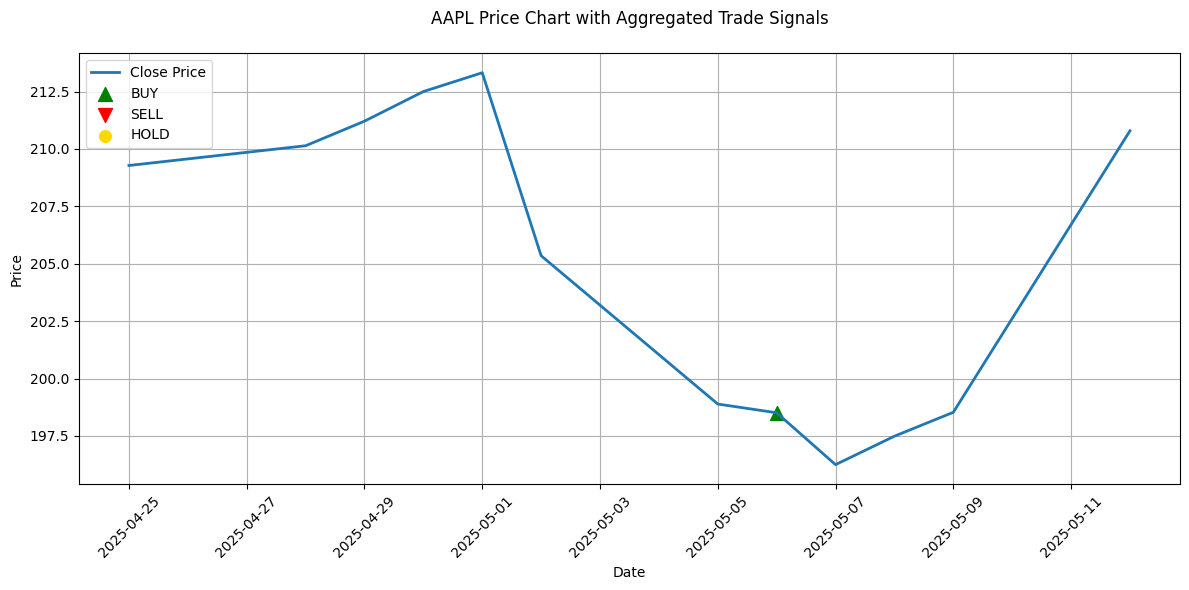

Plotting signal for NFLX...


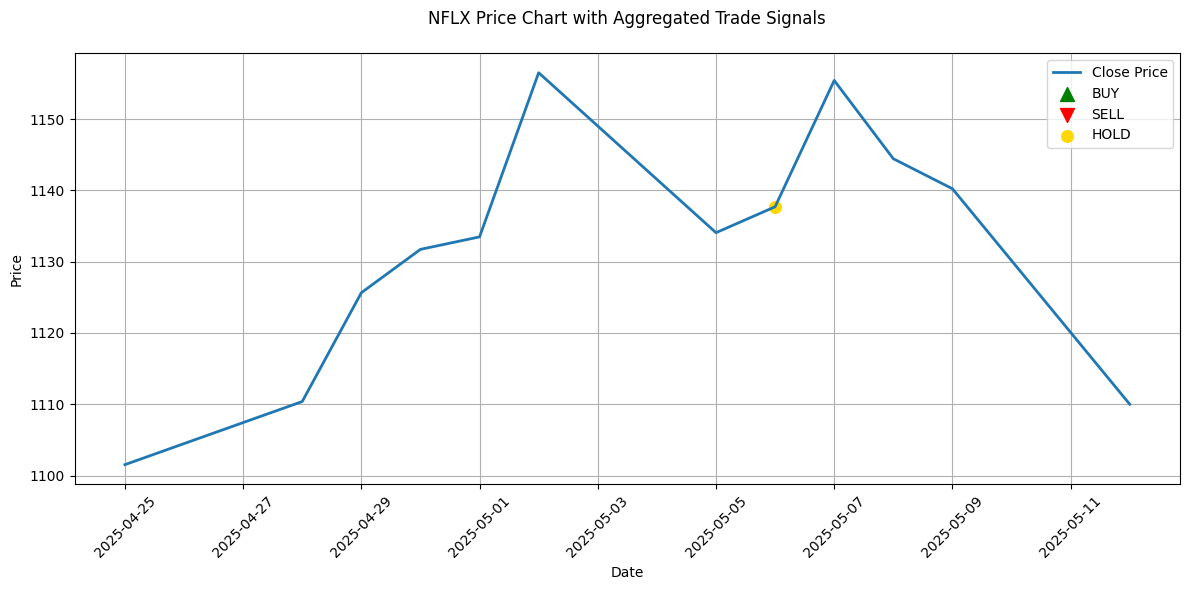

Plotting signal for NVDA...


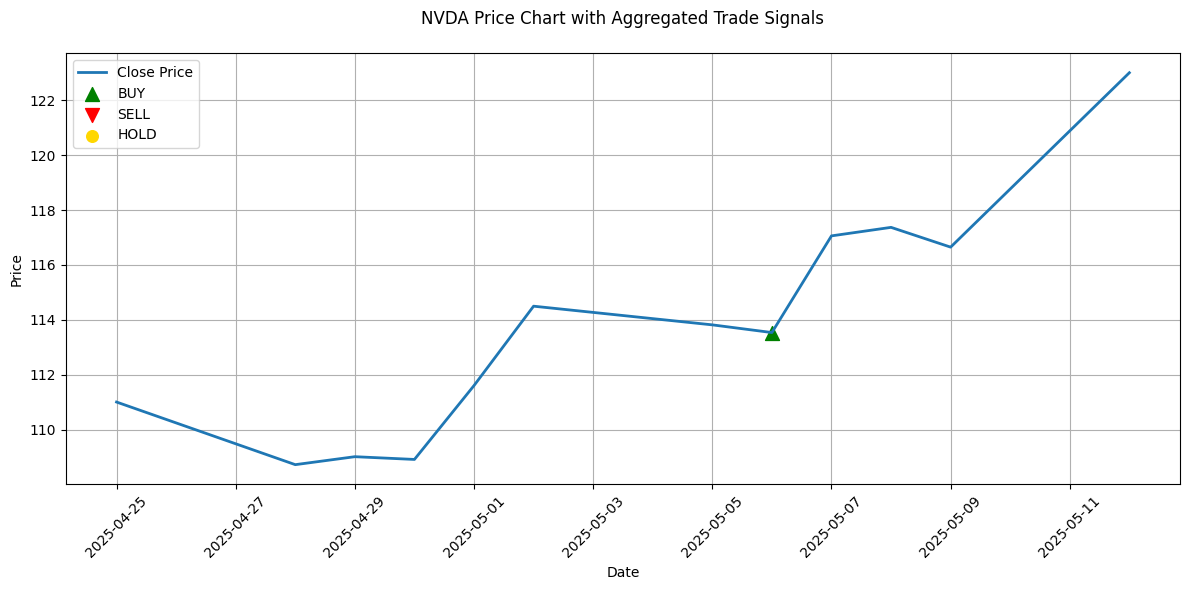

Plotting signal for SPY...


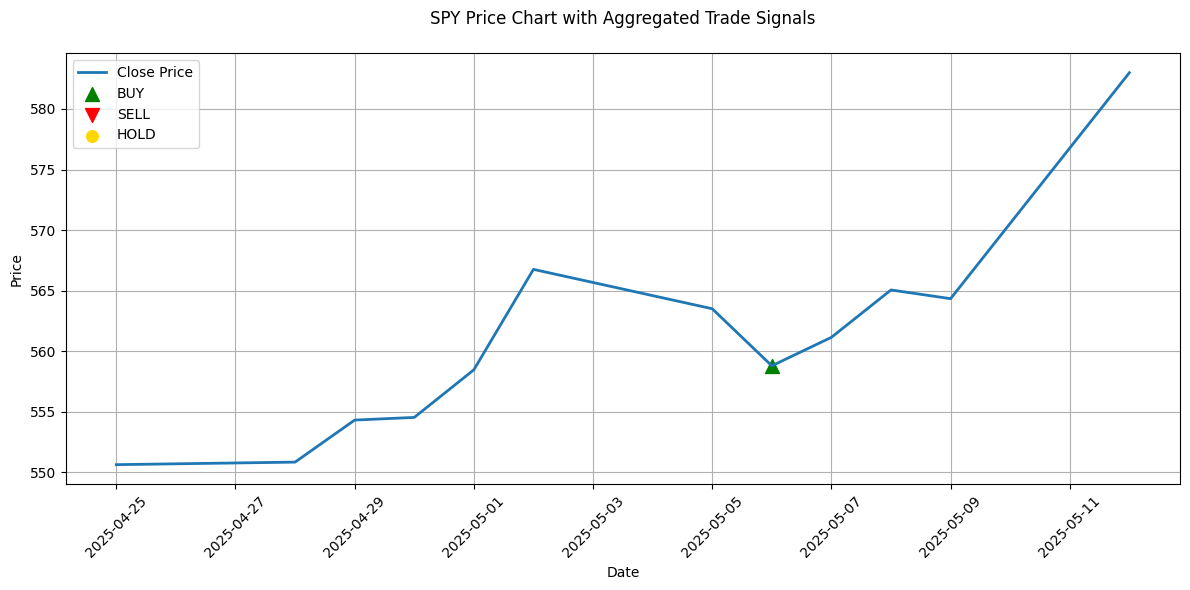

Plotting signal for TSLA...


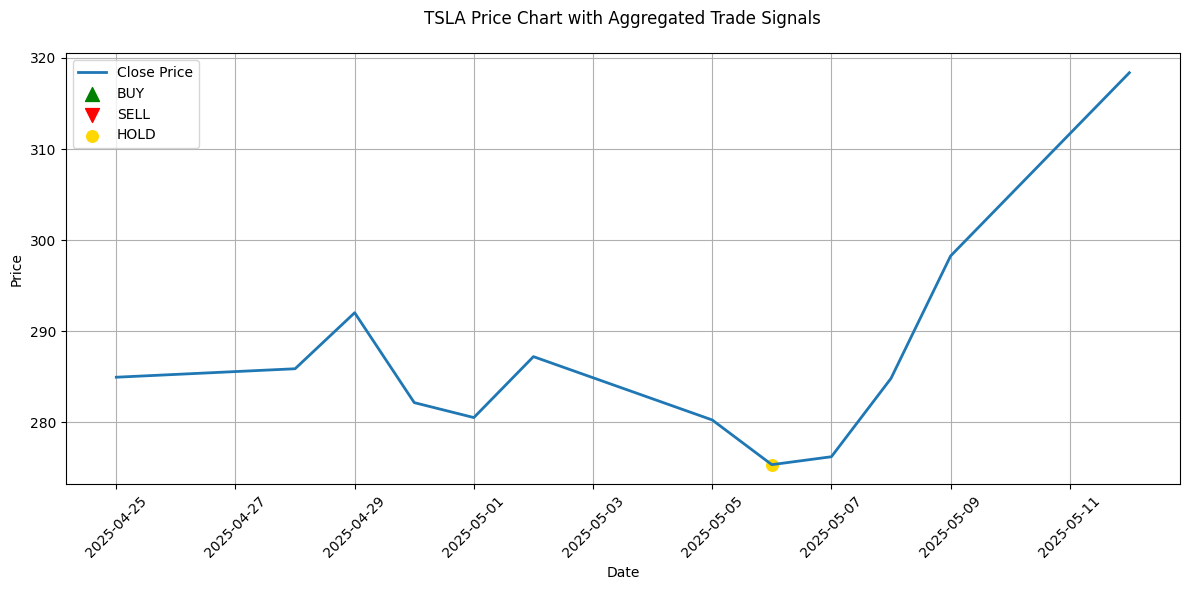

In [17]:
def plot_all_tickers(aggregated_df):
    tickers = aggregated_df["ticker"].unique()

    for ticker in tickers:
        print(f"Plotting signal for {ticker}...")
        plot_signals(aggregated_df, ticker)

plot_all_tickers(aggregated_df)

# Backtesting

In [18]:
import datetime
import yfinance as yf
import pandas as pd

# Virtual Portfolio
initial_capital = 100000.0
portfolio_value = initial_capital
cash_balance = initial_capital
stock_holdings = 0
buy_date = None
buy_price = None
buy_ticker = None

trade_log = []

def is_weekend(date):
    return date.weekday() >= 5

def get_next_valid_date(date):
    while is_weekend(date):
        date += datetime.timedelta(days=1)
    return date.strftime("%Y-%m-%d")

def get_stock_data(ticker, target_date, search_range=5):
    target = pd.to_datetime(target_date)

    for offset in range(-search_range, search_range + 1):
        check_date = target + pd.Timedelta(days=offset)
        if is_weekend(check_date):
            continue

        start_date = check_date.strftime("%Y-%m-%d")
        end_date = (check_date + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

        try:
            price_data = yf.download(ticker, start=start_date, end=end_date, progress=False, interval="1d")
            if not price_data.empty:
                open_price = price_data['Open'].iloc[0]
                close_price = price_data['Close'].iloc[0]
                return open_price, close_price
        except Exception as e:
            print(f"Error fetching data for {ticker} on {check_date.date()}: {e}")

    print(f"No price data found for {ticker} within ±{search_range} days of {target_date}")
    return None, None



# backtesting loop
for i, row in aggregated_df.iterrows():
    trade_date = row['date']
    ticker = row['ticker']
    action = row['final_decision']

    if isinstance(trade_date, pd.Timestamp):
        trade_date = trade_date.strftime("%Y-%m-%d")

    next_date = datetime.datetime.strptime(trade_date, "%Y-%m-%d") + datetime.timedelta(days=1)
    next_valid_date = get_next_valid_date(next_date)

    open_price, close_price = get_stock_data(ticker, next_valid_date, search_range=5)

    if open_price is None or close_price is None:
        continue

    daily_profit = 0.0
    if action == "HOLD":
        pass
    elif action == "BUY" and stock_holdings == 0:
        buy_date = next_valid_date
        buy_price = open_price
        buy_ticker = ticker
        shares = cash_balance / buy_price
        if isinstance(shares, pd.Series):
            shares = shares.iloc[0]
        shares = float(shares)

        stock_holdings = shares

        stock_holdings = shares
        cash_balance -= shares * buy_price
    elif action == "SELL" and float(stock_holdings) > 0 and buy_date is not None:
        hold_days = (datetime.datetime.strptime(next_valid_date, "%Y-%m-%d") -
                    datetime.datetime.strptime(buy_date, "%Y-%m-%d")).days
        if hold_days >= 2:
            value_from_sale = stock_holdings * close_price
            cash_balance += value_from_sale
            daily_profit = value_from_sale - (stock_holdings * buy_price)
            portfolio_value = cash_balance

            trade_log.append({
                "date": next_valid_date,
                "ticker": ticker,
                "action": "SELL",
                "open": round(open_price, 2),
                "close": round(close_price, 2),
                "daily_profit": round(daily_profit, 2),
                "portfolio_value": round(portfolio_value, 2),
                "cash_balance": round(cash_balance, 2),
                "stock_holdings": 0
            })

            stock_holdings = 0
            buy_date = buy_price = buy_ticker = None

if isinstance(stock_holdings, pd.Series):
    stock_holdings = stock_holdings.iloc[0]
stock_holdings = float(stock_holdings)

if stock_holdings > 0 and buy_date is not None:
  if isinstance(cash_balance, pd.Series):
      cash_balance = cash_balance.iloc[0]
  if isinstance(close_price, pd.Series):
      close_price = close_price.iloc[0]
  if isinstance(stock_holdings, pd.Series):
      stock_holdings = stock_holdings.iloc[0]

portfolio_value = float(cash_balance) + float(stock_holdings) * float(close_price)


trade_log.append({
    "date": next_valid_date,
    "ticker": buy_ticker,
    "action": "HOLD",
    "open": round(open_price, 2),
    "close": round(close_price, 2),
    "daily_profit": round(daily_profit, 2),
    "portfolio_value": round(portfolio_value, 2),
    "cash_balance": round(cash_balance, 2),
    "stock_holdings": round(stock_holdings, 2)
})

trade_log_df = pd.DataFrame(trade_log)
trade_log_df.head()

,date,ticker,action,open,close,daily_profit,portfolio_value,cash_balance,stock_holdings
0,2025-05-06,AAPL,HOLD,Ticker TSLA 280.01 Name: 2025-05-01 00:00:0...,280.52,0.0,134168.73,0.0,478.29


# Summary

In [19]:
# profit/loss
profit = portfolio_value - initial_capital
profit_percent = (profit / initial_capital) * 100

# summary
print("Backtest Summary")
print(f" Starting Capital:${initial_capital:,.2f}")
print(f" Final Portfolio Value:${portfolio_value:,.2f}")
print(f" Profit/Loss:${profit:,.2f} ({profit_percent:+.2f}%)")
print(f" Final Cash Balance:${cash_balance:,.2f}")
print(f" Final Stock Holdings:{stock_holdings:.2f} shares")
print(f" Total Trades Executed:{len(trade_log_df)}")
print(f" Last Trade Date:{trade_log_df['date'].iloc[-1] if not trade_log_df.empty else 'N/A'}")
print(f" Last Action Taken:{trade_log_df['action'].iloc[-1] if not trade_log_df.empty else 'N/A'}")


Backtest Summary
 Starting Capital:$100,000.00
 Final Portfolio Value:$134,168.73
 Profit/Loss:$34,168.73 (+34.17%)
 Final Cash Balance:$0.00
 Final Stock Holdings:478.29 shares
 Total Trades Executed:1
 Last Trade Date:2025-05-06
 Last Action Taken:HOLD
